# Generate comCam simulation data with imsim
similar to https://jira.lsstcorp.org/browse/DM-35005  
    
    
Use opSim to provide visit-specific information,  sourced with GAIA DR2.  


We run imSim with an extended stack version. The specific setup included 

    source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2023_32/loadLSST-ext.bash 
    setup lsst_distrib
    export IMSIM_HOME=/sdf/home/s/scichris/link_to_scichris/WORK/imsim_home
    export RUBIN_SIM_DATA_DIR=$IMSIM_HOME/rubin_sim_data
    
    export SIMS_SED_LIBRARY_DIR=$IMSIM_HOME/rubin_sim_data/sims_sed_library

    setup -k -r $IMSIM_HOME/imSim 
    setup -k -r $IMSIM_HOME/skyCatalogs
    

We generate the focus sweep by submitting the same imsim yaml config file, but changing


    input.telescope.focusZ: 0.0015   # telescope offset is in meters

    output.header:
        focusZ: 1.5   # header is in mm
        seqnum: 942

We also need to ensure that FFT doesn't get triggered with very bright sources (it would create an in-focus saturated star instead of a defocal donut - see discussion https://lsstc.slack.com/archives/CHXKSF3HC/p1697746954341459

"There is a bug (see a lot of discussion above) that if an object is too bright, then we do an FFT instead of ray tracing.  But the FFT doesn’t know about out of focus things so it still makes an in-focus star.  We missed this case when designing it (super bright things we can’t ray trace on out of focus sensors). (edited) 

We need to determine what sensors are out of focus and then treat the bright objects differently. Exactly what we will do is under discussion, but maybe clip the flux and rescale tje results. In fact the image above with the #, is from a very long run with no FFTs so we could study what very brighnt donuts look like."  Chris W. via Slack, 2023-10-19, 1:22 pm


The source brightness can be limit by setting:

    input.sky_catalog:
    max_flux: 1e7

We also generate OPD, by providing imsim with location of CCD centers:

In [3]:
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE, FOCAL_PLANE
from lsst.geom import Point2D
from astropy.table import Table
import lsst.obs.lsst as obs_lsst


camera =  obs_lsst.LsstCam().getCamera()

# only for instName = "lsst"   
fieldX, fieldY = list(), list()
fieldXrad, fieldYrad = list(), list()
detName = list()

raft = 'R22'
all_detectors = list(camera.getNameMap().keys())
raft_detectors = [name  for name in all_detectors if name.startswith(raft)]
print(raft_detectors)

xps, yps = [],[]
for name in raft_detectors:
    detector = camera.get(name) 
    # xp, yp = detector.getCenter(FOCAL_PLANE) # in mm 
    xp_rad, yp_rad = detector.getCenter(FIELD_ANGLE)  # in radians 
    xp_deg =  np.rad2deg(xp_rad)
    yp_deg = np.rad2deg(yp_rad)
    print(name, detector.getId(), xp_deg, yp_deg)
    xps.append(xp_deg)
    yps.append(yp_deg)
    
    
# print in a format expected by imsim 

i=0
for name in raft_detectors:
    print("    - thx:", xps[i], "deg")
    print("      thy:", yps[i], "deg ")#"# ", name)
    i+=1 
    
    
    


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


['R22_S01', 'R22_S11', 'R22_S02', 'R22_S12', 'R22_S00', 'R22_S10', 'R22_S20', 'R22_S21', 'R22_S22']


NameError: name 'np' is not defined

Note that although we don't use out-of-focus OPD, it only takes ~45 sec to generate it, so it was deemed not necessary to not simulate it for the defocal images.

We simulate different `focusZ`  ensuring that each image  gets a different `seqNum`, since that's used to create the exposure number, and allows for butler ingestion, eg.  


    galsim imsim-run-R22-defocal.yaml   input.telescope.focusZ=-0.0015 output.header.focusZ=-1.5    output.header.seqnum=940

The `imsim-config.yaml` contains:


    modules: [imsim]
    template: imsim-config-skycat

    # Use skyCatalogs for obtaining the objects to render.
    input.sky_catalog:
      file_name: /sdf/data/rubin/user/jchiang/imSim/skyCatalogs_v2/skyCatalog.yaml
      approx_nobjects: 1000
      band: { type: OpsimData, field: band }
      mjd: { type: OpsimData, field: mjd }
      obj_types: [gaia_star]
      max_flux: 1e7 

    input.opsim_data.file_name: /sdf/data/rubin/user/jchiang/imSim/rubin_sim_data/opsim_cadences/baseline_v3.2_10yrs.db
    input.opsim_data.visit: 740000

    input.atm_psf.screen_size: 819.2
    input.atm_psf.save_file:
      type: FormattedStr
      format: atm_psf_files/atm_psf_%08d-%1d-%s.pkl
      items:
          - { type: OpsimData, field: observationId }
          - { type: OpsimData, field: snap }
          - { type: OpsimData, field: band }

    # offset the piston by 1.5 mm 
    input.telescope.focusZ: 0   # telescope offset is in meters

    # disable checkpointing
    input.checkpoint: ""

    image.random_seed: '@input.opsim_data.visit'

    # simulate no objects for OPD-only
    #image.nobjects: 0

    output.nproc: 9
    output.det_num.first: 90 # ensures we only simulate R22 
    output.nfiles: 9

    # make no amp images
    #output.readout: ""

    output.header:
        focusZ: 0.0   # header is in mm 
        seqnum: 941   # this needs to be different for each focus setting for the same visit 

    output.camera: LsstCam
    output.dir:
        type: FormattedStr
        format : output_all_R22/%08d
        items:
            - "@input.opsim_data.visit"

    # create OPD at all R22 locations 
    #R22_S01 91 0.0 -0.23472222222222222
    #R22_S11 94 0.0 0.0
    #R22_S02 92 0.23472222222222225 -0.23472222222222225
    #R22_S12 95 0.23472222222222222 0.0
    #R22_S00 90 -0.23472222222222225 -0.23472222222222225
    #R22_S10 93 -0.23472222222222222 0.0
    #R22_S20 96 -0.23472222222222225 0.23472222222222225
    #R22_S21 97 0.0 0.23472222222222222
    #R22_S22 98 0.23472222222222225 0.23472222222222225
    
    output.opd:
        file_name:
            type: FormattedStr
            format: opd_%s.fits.fz
            items:
                - "@input.telescope.focusZ"
        rotTelPos:  "@input.telescope.rotTelPos"
        fields:
        - thx: 0.0 deg
          thy: -0.23472222222222222 deg 
        - thx: 0.0 deg
          thy: 0.0 deg 
        - thx: 0.23472222222222225 deg
          thy: -0.23472222222222225 deg 
        - thx: 0.23472222222222222 deg
          thy: 0.0 deg 
        - thx: -0.23472222222222225 deg
          thy: -0.23472222222222225 deg 
        - thx: -0.23472222222222222 deg
          thy: 0.0 deg 
        - thx: -0.23472222222222225 deg
          thy: 0.23472222222222225 deg 
        - thx: 0.0 deg
          thy: 0.23472222222222222 deg 
        - thx: 0.23472222222222225 deg
          thy: 0.23472222222222225 deg 

    # apply specific formatting to the amp images 
    output.readout.file_name:
        type: FormattedStr
        format : amp_%08d-%1d-%s-%s-det%03d-%s.fits.fz
        items:
            - "@input.opsim_data.visit"  # eg. 00740000
            - 0   # snap 
            - $band  # eg. g
            - $det_name  # eg. R22_S10 
            - "@output.det_num"  # eg. 91--> 091  
            - "@input.telescope.focusZ" #  eg. 0.0015 

    output.timeout: 1e5
    output.truth.dir: '@output.dir'
    output.truth.file_name.format: centroid_%08d-%1d-%s-%s-det%03d.txt.gz

Choose a visit from opsim db.  We can **try** to match the ra/dec of the original LVV-T2229 pointing by querying opsim db:

In [4]:
import sqlite3
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from astropy.coordinates import SkyCoord
from astropy import units as u

# We could find visits that are close to a given ra/dec, 
#like in https://jira.lsstcorp.org/browse/DM-35005

#  ra            dec 
# 20:28:18.74 -87:28:19.9 (original target, with PA=0º)
                             
c0 = SkyCoord('20:28:18.74 -87:28:19.9', unit=(u.hourangle, u.deg))


columns = '*'

opsim_db_file = '/sdf/data/rubin/user/jchiang/imSim/rubin_sim_data/opsim_cadences/baseline_v3.2_10yrs.db'

ra0 = c0.ra.deg
dec0 =  c0.dec.deg
delta = 1 # deg 

query = (f"select {columns} from observations "
         f"where ({ra0 - delta} < fieldRA) "
         f"and (fieldRA < {ra0 + delta}) "
         f"and ({dec0 - delta} < fieldDec) "
         f"and (fieldDec < {dec0 + delta})")

with sqlite3.connect(opsim_db_file) as con:
    df0 = pd.read_sql(query, con)
    

In [7]:
df0[['observationId','fieldRA','fieldDec',
         'observationStartMJD', 'visitExposureTime', 
         'night','airmass','skyBrightness','sunAlt',
         'moonDistance','moonPhase' ]]

,observationId,fieldRA,fieldDec,observationStartMJD,visitExposureTime,night,airmass,skyBrightness,sunAlt,moonDistance,moonPhase
0,68609,306.661504,-86.924706,60907.222885,30.0,111,1.843517,22.577148,-70.460814,119.609695,20.754213
1,68659,306.661504,-86.924706,60907.246674,30.0,111,1.857446,22.030924,-66.027409,119.593130,20.551207
2,726966,306.608899,-87.397563,61984.000545,30.0,1188,1.929010,18.626410,-24.025511,62.463349,72.526945
3,1429362,307.898688,-87.230149,63240.216662,30.0,2444,2.162996,21.853259,-37.328838,70.949817,27.341871
4,1429412,307.898688,-87.230149,63240.242674,30.0,2444,2.167267,20.789772,-35.672059,70.843448,27.115905
5,2032781,306.709935,-87.895073,64323.253059,30.0,3527,2.117906,18.531647,-33.066577,109.194879,85.410819
6,2032831,306.709935,-87.895073,64323.278912,30.0,3527,2.120317,19.033075,-29.443312,109.137269,85.291565


We see that even with such large allowance for pointing, only a few visits actually have a dark moon (phase < 30%) and good moon separation (>100 deg), so that lunar illumination doesn't cause any additional background...

Let's choose 68659 since it's particularly dark night (only 20% lunar phase, 120 deg away, and the sun is ~60 deg below the horizon.

In [20]:
df0_select = df0[df0['observationId'] == 68659]

In [21]:
df0_select

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,airmass,seeingFwhm500,seeingFwhmEff,seeingFwhmGeom,skyBrightness,night,slewTime,visitTime,slewDistance,fiveSigmaDepth,altitude,azimuth,paraAngle,cloud,moonAlt,sunAlt,note,target,fieldId,proposalId,block_id,observationStartLST,rotTelPos,rotTelPos_backup,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id
1,68659,306.661504,-86.924706,60907.246674,60907.251796,30.0,g,285.230776,285.230776,2,1.857446,0.589094,1.223033,1.057333,22.030924,111,9.405863,34.0,3.207455,24.179729,32.57299,182.354017,41.406847,0.0,-43.117107,-66.027409,"pair_33, ug, b",,-1,81,1,346.8805,-33.362377,-47.621862,80.618694,134.791048,149.333306,12.46765,112.861448,26.609109,119.59313,105.302361,20.551207,-48.434874,0


Generate slurm submission scripts. We change the visit number,  focusZ in the `input.telescope` and `output.header`, as well as `seqNum` in the header:
    
    
    galsim imsim-run-R22-defocal.yaml input.opsim_data.visit=68659  input.telescope.focusZ=-0.0015 output.header.focusZ=-1.5    output.header.seqnum=940
    
    
    
    

In [12]:
import os 

nodes=2
thrs= 100 # for some jobs 5 hrs this is insufficient
partition='milano'
mem=100 # GB, should be generally output.nproc*6GB , so here 9*6GB = 54 GB 
visit = 68659
seqNum = 940

def write_to_file(out_file, content):
    with open(out_file, "w") as output:
        for line in content:
            output.write(line)
# Note that in the output directory we need to make the `atm_psf_files` 
# directory (it doesn't get made automatically, as eg `output_all_R22` with the amp files does):
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679/'
atm_files_dir = os.path.join(path_cwd, 'atm_psf_files')
if not os.path.exists(atm_files_dir):
    os.makedirs(atm_files_dir)

for focusz_mm in  [-0.0015,0,0.0015]:

    print(visit, focusz_mm)
    
    slurm_file = os.path.join(path_cwd, f'runSlurm_comcam-{visit}-{seqNum}.sl')

    # the instance catalog to use ... 
    path_to_imsim_yaml = os.path.join(path_cwd,'imsim-run-R22-defocal.yaml')
    cmd = f"galsim {path_to_imsim_yaml} input.opsim_data.visit={visit}\
    input.telescope.focusZ={focusz_mm} output.header.focusZ={1000*focusz_mm}\
    output.header.seqnum={seqNum}"

    path_to_slurm_log = os.path.join(path_cwd, f'{visit}_{seqNum}.out')
    content = ['#!/bin/bash -l \n',
              f'#SBATCH --partition {partition} \n',
              '#SBATCH --account rubin:developers \n',
              f'#SBATCH --nodes {nodes} \n',
              f'#SBATCH --mem={mem}G \n',
              f'#SBATCH --cpus-per-task=9\n',
              f'#SBATCH -t {thrs}:00:00 \n', 
              f'#SBATCH --job-name {visit}{seqNum} \n'
              f'#SBATCH --output={path_to_slurm_log} \n',
                'echo "starting at `date` on `hostname`" \n',
                "pwd \n",
                 cmd,
                '\n echo "ended at `date` on `hostname`" \n',
              ]
    write_to_file(slurm_file, content)

    seqNum += 1 # ensure it's different for each defocal offset


68659 -0.0015
68659 0
68659 0.0015


We can submit all these with `submit_slurm.py` script:
    

In [ ]:
# contents of `submit_slurm.py` script
# need to be run from terminal where
# imsim is available 
import subprocess
import os
flist = [f  for f in os.listdir(os.getcwd()) if f.startswith('runSlurm') ]
for i in range(len(flist)):
    slurm_file = flist[i]
    print(f"Running sbatch  {slurm_file}")
    subprocess.call(["sbatch", slurm_file])

We generate a gen3 repo:

In [13]:
from lsst.ts.wep.utils import  runProgram
butlerRootPath = os.path.join(path_cwd, 'gen3repo')
runProgram(f"butler create {butlerRootPath}")
runProgram(f"butler register-instrument {butlerRootPath} lsst.obs.lsst.LsstCam")

We ingest the GAIA DR2 refcat: 


In [16]:
ecsvPath = "/sdf/data/rubin/repo/aos_imsim/gaia_dr2_20200414.ecsv"
collection = "refcats/gaia_dr2_20200414"
datasetType = "gaia_dr2_20200414"

runProgram(f"butler register-dataset-type {butlerRootPath}"
           f" {datasetType} SimpleCatalog htm7")
runProgram(f"butler ingest-files -t direct {butlerRootPath}"
           f"  {datasetType} {collection}  {ecsvPath} --prefix /sdf/group/rubin")
runProgram(f"butler collection-chain {butlerRootPath} --mode extend refcats {collection}")

Dataset type successfully registered.


lsst.daf.butler.script.ingest_files INFO: Ingesting 131072 dataset ref(s) from 131072 file(s)


[refcats/gaia_dr2_20200414]


Write calibs once:

In [3]:
from lsst.daf import butler as dafButler
from lsst.ts.wep.utils import  runProgram

path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo')
butler = dafButler.Butler(butlerRootPath)
butlerInstName = 'Cam'
if f"LSST{butlerInstName}/calib" not in butler.registry.queryCollections():
    print("Ingesting curated calibrations.")

    runProgram(
        f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
    )

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Ingesting curated calibrations.


lsst.obs.base._instrument INFO: Processing 'transmission_sensor' curated calibration


Ingest raws:

In [4]:
outputImgDir = os.path.join(path_cwd, 'output_all_R22', '00068659')

In [5]:
runProgram(f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*")
runProgram(f"butler define-visits {butlerRootPath} lsst.obs.lsst.LsstCam")
    

lsst.ingest INFO: Successfully extracted metadata from 27 files with 0 failures
lsst.ingest INFO: Exposure LSSTCam:IM_P_20250820_000940 ingested successfully
lsst.ingest INFO: Exposure LSSTCam:IM_P_20250820_000941 ingested successfully
lsst.ingest INFO: Exposure LSSTCam:IM_P_20250820_000942 ingested successfully
lsst.ingest INFO: Successfully processed data from 3 exposures with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 27 distinct Butler datasets
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 0: one-to-one.
lsst.defineVisits INFO: Registering visit_system 2: by-seq-start-end.
lsst.defineVisits INFO: Grouping 3 exposure(s) into visits.
lsst.defineVisits INFO: Computing regions and other metadata for 3 visit(s).


See what got ingested:

In [6]:
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = butler.registry.queryDatasets(datasetType='raw',collections=['LSSTCam/raw/all']).expanded()
for ref  in datasetRefs:
    print(ref)

raw@{instrument: 'LSSTCam', detector: 92, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=9bee90c3-f85f-5776-91ca-b89aeb76f88b)
raw@{instrument: 'LSSTCam', detector: 96, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=e02aa368-ac70-50ed-bd2b-e2e7bc877761)
raw@{instrument: 'LSSTCam', detector: 98, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=36e01ad4-f1dd-5c4c-b514-3e1030fee731)
raw@{instrument: 'LSSTCam', detector: 97, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=01910a8f-c607-52b3-93a0-ad25ca54ebb4)
raw@{instrument: 'LSSTCam', detector: 90, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=d3d89178-e636-507d-991a-97d4e64a0eeb)
raw@{instrument: 'LSSTCam', detector: 94, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=da23b26c-24ab-5c42-b695-de0b4dd3bd15)
raw@{instrument: 'LSSTCam', detector: 95, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=e8

In [7]:
ref.dataId.records['exposure']

exposure.RecordClass(instrument='LSSTCam', id=5025082000942, physical_filter='g_6', obs_id='IM_P_20250820_000942', exposure_time=15.0, dark_time=15.0, observation_type='science', observation_reason='survey', day_obs=20250820, seq_num=942, seq_start=942, seq_end=942, group_name='5025082000942', group_id=5025082000942, target_name='UNKNOWN', science_program='68659', tracking_ra=306.66150424023687, tracking_dec=-86.92470618735807, sky_angle=344.4696271705218, azimuth=None, zenith_angle=None, has_simulated=True, timespan=Timespan(begin=astropy.time.Time('2025-08-20 05:55:12.641229', scale='tai', format='iso'), end=astropy.time.Time('2025-08-20 05:55:27.641000', scale='tai', format='iso')))

First run ISR only, since WEP wouldn't know what to do with an in-focus image:

In [18]:
from lsst.ts.wep.utils import getConfigDir as getWepConfigDir
def writeWepConfigurationIsrOnly(instName, pipelineYamlPath):
        """Write wavefront estimation pipeline task configuration.

        Parameters
        ----------
        instName : str
            Name of the instrument this configuration is intended for.
        pipelineYamlPath : str
            Path where the pipeline task configuration yaml file
            should be saved.
        filterTypeName : str
            Filter type name: ref (or ''), u, g, r, i, z, or y.
        """

        butlerInstName = "Cam"

        with open(pipelineYamlPath, "w") as fp:
            fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing
description: basic processing pipeline with imsim
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Use imported instrument configuration
#imports:
#  - location: {getWepConfigDir()}/cwfs/instData/{instName}/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
      python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
"""
            )
instName = 'lsst'
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineISR.yaml")

writeWepConfigurationIsrOnly(instName, pipelineYamlPath)   


Test the query : 

In [9]:
datasetRefs = registry.queryDatasets('raw',collections=['LSSTCam/raw/all'],
                                     where=f"instrument='LSSTCam' and exposure.day_obs=20250820").expanded()

In [12]:
for ref in datasetRefs:
    print(ref)

raw@{instrument: 'LSSTCam', detector: 90, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=d3d89178-e636-507d-991a-97d4e64a0eeb)
raw@{instrument: 'LSSTCam', detector: 90, exposure: 5025082000941, ...} [sc=Exposure] (run=LSSTCam/raw/all id=2d9e69f2-85d5-56b5-adc4-f07d385a727c)
raw@{instrument: 'LSSTCam', detector: 90, exposure: 5025082000942, ...} [sc=Exposure] (run=LSSTCam/raw/all id=f38834e5-5289-5f0f-b2f4-a8e5dba05809)
raw@{instrument: 'LSSTCam', detector: 91, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=fa3f39ad-a705-5361-9c5f-e1a11a7f4be1)
raw@{instrument: 'LSSTCam', detector: 91, exposure: 5025082000941, ...} [sc=Exposure] (run=LSSTCam/raw/all id=946f6a5c-8111-56bb-a710-418842f8cf8f)
raw@{instrument: 'LSSTCam', detector: 91, exposure: 5025082000942, ...} [sc=Exposure] (run=LSSTCam/raw/all id=56bcb667-53a2-5323-84e6-19c7693e96d1)
raw@{instrument: 'LSSTCam', detector: 92, exposure: 5025082000940, ...} [sc=Exposure] (run=LSSTCam/raw/all id=9b

In [16]:
len(list(datasetRefs))

27

Run ISR with that query:

In [19]:
# 1) run ISR only : seleect by obs day since there aren;t any other visits we're simulating now ...
butlerInstName = 'Cam'
runName = 'run1'
numPro=5

runProgram(f"pipetask run -b {butlerRootPath} "
            f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "
            f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "
            f"--register-dataset-types --output-run {runName}  -p {pipelineYamlPath} -d "
           f'"exposure.day_obs=20250820" -j {numPro}'
          )

# or use exposure.science_program={}

lsst.pipe.base.quantum_graph_builder INFO: Processing pipeline subgraph 1 of 1 with 1 task(s).
lsst.pipe.base.quantum_graph_builder INFO: Iterating over query results to associate quanta with datasets.
lsst.pipe.base.quantum_graph_builder INFO: Initial bipartite graph has 27 quanta, 110 dataset nodes, and 108 edges from 27 query row(s).
lsst.pipe.base.quantum_graph_builder INFO: Generated 27 quanta for task isr.
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 27 quanta for 1 task, graph ID: '1699659785.033567-3346463'
Quanta Tasks
------ -----
    27   isr
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LSSTCam', detector: 94, exposure: 5025082000942, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LSSTCam', detector: 96, exposure: 5025082000942, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId=

lsst.isr WARNING: No rough magnitude zero point defined for filter g_6.
lsst.isr INFO: Setting rough magnitude zero point for filter g_6: 30.940228
lsst.isr WARNING: No rough magnitude zero point defined for filter g_6.
lsst.isr INFO: Setting rough magnitude zero point for filter g_6: 30.940228
lsst.isr WARNING: No rough magnitude zero point defined for filter g_6.
lsst.isr INFO: Setting rough magnitude zero point for filter g_6: 30.940228
lsst.isr WARNING: No rough magnitude zero point defined for filter g_6.
lsst.isr INFO: Setting rough magnitude zero point for filter g_6: 30.940228
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 93, exposure: 5025082000942, ...} took 8.563 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 6 quanta successfully, 0 failed and 21 remain out of total 27 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LSSTCam', de

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=isr dataId={instrument: 'LSSTCam', detector: 93, exposure: 5025082000940, ...}.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_6.
lsst.isr INFO: Setting rough magnitude zero point for filter g_6: 30.940228
lsst.isr WARNING: No rough magnitude zero point defined for filter g_6.
lsst.isr INFO: Setting rough magnitude zero point for filter g_6: 30.940228
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector:

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 91, exposure: 5025082000942, ...} took 10.115 seconds
lsst.isr INFO: Converting exposure to floating point values.
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 24 quanta successfully, 0 failed and 3 remain out of total 27 quanta.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_6.
lsst.isr INFO: Setting rough magnitude zero point for filter g_6: 30.940228
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 93, exposure: 5025082000941, ...} took 11.916 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 25 quanta successfully, 0 failed and 2 remain out of total 27 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on 

Show the postISR images:

In [20]:
from lsst.daf import butler as dafButler


butler = dafButler.Butler(butlerRootPath)

runName = 'run1'

exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LSSTCam', 'detector':93,  # this one has focusZ -0.0015 
                                           'exposure':5025082000940}, collections=[runName])

exposure_focus = butler.get('postISRCCD', dataId={'instrument':'LSSTCam', 'detector':93,  # this one has focusZ 0.0015 
                                           'exposure':5025082000941}, collections=[runName])

exposure_extra  = butler.get('postISRCCD', dataId={'instrument':'LSSTCam', 'detector':93,  # this one has focusZ 0.0015 
                                           'exposure':5025082000942}, collections=[runName])

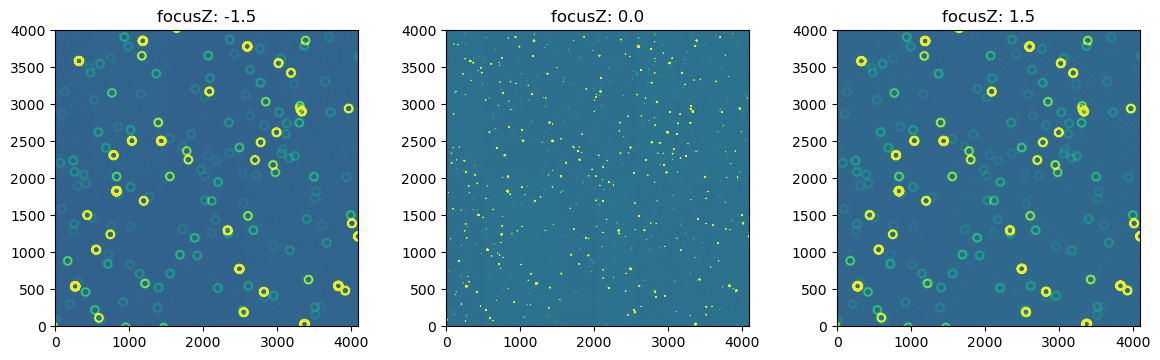

In [23]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
fig,ax = plt.subplots(1,3, figsize=(14,5))

zscale = ZScaleInterval()
i=0
for exposure in [exposure_intra, exposure_focus, exposure_extra]:
    d = exposure.image.array
    focusz = exposure.visitInfo.focusZ
    vmin,vmax = zscale.get_limits(d)
    mappable = ax[i].imshow(d, vmin=vmin, vmax=vmax, origin='lower')
    
    ax[i].set_title(f'focusZ: {focusz}')
    i += 1 
#fig.suptitle( f'detector: {exposure.detector.getId()} ({exposure.detector.getName()})')
#plt.colorbar(mappable, ax=ax[1]) 
fig.subplots_adjust(wspace=0.29)

Then run WEP, feeding as an input the postISRCCD. We use https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testCalcZernikesScienceSensorPipeline.yaml and https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testDonutCatWcsPipeline.yaml as an inspiration:


In [7]:
from lsst.ts.wep.utils import getConfigDir as getWepConfigDir
def writeWepConfigurationWepOnly(instName, pipelineYamlPath):
        """Write wavefront estimation pipeline task configuration.

        Parameters
        ----------
        instName : str
            Name of the instrument this configuration is intended for.
        pipelineYamlPath : str
            Path where the pipeline task configuration yaml file
            should be saved.
        filterTypeName : str
            Filter type name: ref (or ''), u, g, r, i, z, or y.
        """

        butlerInstName = "Cam"

        with open(pipelineYamlPath, "w") as fp:
            fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing
description: basic processing pipeline with imsim
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Use imported instrument configuration
#imports:
#  - location: {getWepConfigDir()}/cwfs/instData/{instName}/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    config:
    # this config points to the GAIA DR2 refcat
      connections.refCatalogs: gaia_dr2_20200414
      anyFilterMapsToThis: phot_g_mean
      donutSelector.useCustomMagLimit: True
      donutSelector.magMax: 25.0
      donutSelector.magMin: 10.0
      donutSelector.unblendedSeparation: 1
  cutOutDonutsScienceSensorTask:
    class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
    config:
      # And here we specify the configuration settings originally defined in
      # CutOutDonutsScienceSensorTaskConfig.
      # Test Science Sensor pipeline works when specifying instrument configuration
      donutTemplateSize: 160
      donutStampSize: 160
      initialCutoutPadding: 40
  calcZernikesTask:
    class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
    """)
    
    
instName = 'lsst'
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineWEP.yaml")
writeWepConfigurationWepOnly(instName, pipelineYamlPath)   



Note: ISR and WEP must be run with the same `lsst_distrib`. Otherwise we'll get a version mismatch ... 

In [ ]:
from lsst.ts.wep.utils import  runProgram
butlerInstName = 'Cam'
runName = 'run1'
numPro=5
instName = 'lsst'
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo')
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineWEP.yaml")
for detNum in range(90,99):
    cmd = f"pipetask run -b {butlerRootPath} "+\
                f"-i refcats/gaia_dr2_20200414,{runName},LSST{butlerInstName}/calib/unbounded "+\
                f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "+\
                f"--register-dataset-types --output-run {runName}  --extend-run  -p {pipelineYamlPath} -d "+\
               f'"exposure.seq_num in (940,942) and detector={detNum}" -j {numPro}'
    print('Running', cmd)
    runProgram(cmd)

In [ ]:
registry = butler.registry
collectionsList = list(registry.queryCollections())
print(collectionsList)

butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetTypes = list(registry.queryDatasetTypes())
for dt in datasetTypes:
    print(dt)
    

Obtain the donut catalog :

In [ ]:
from lsst.daf import butler as dafButler

collection = 'run1'
instrument= 'LSSTCam'
detector=90
exposure_number = 5028081900942
butlerRootPath = '/sdf/home/s/scichris/link_to_scichris/WORK/opsim_imsim_test/gen3repo_all/'
butler = dafButler.Butler(butlerRootPath)


# construct a dataId  for postISR
data_id = {
    "detector": detector,
    "instrument": instrument,
    "exposure": exposure_number,
}

# read the postISR exposure
exposure = butler.get("postISRCCD", data_id, collections=[collection])



datasetRefs = registry.queryDatasets("zernikeEstimateRaw",collections='run1',
              where=f"instrument='LSSTCam'").expanded()

for ref in datasetRefs:
    print(ref)
    
# construct a dataId for zernikes and donut catalog:
# switch exposure to visit
data_id = {"detector": detector, "instrument": instrument, "visit": 5028081900942}

# the raw Zernikes are all stored for the extra-focal visit ,,., 
zernikes_raw = butler.get(
    "zernikeEstimateRaw", dataId=data_id, collections=[collection]
)


donut_stamps = butler.get(
    "donutStampsExtra", dataId=data_id, collections=[collection]
)



Overplot the refcat sources on top of the WEP detections. Query the refcat around the fieldRA, fieldDec, that correspond to the visit boresight:


In [ ]:
    
import lsst.daf.butler as daf_butler
from lsst.meas.algorithms import ReferenceObjectLoader
import lsst.geom

collection='refcats/gaia_dr2_20200414' 
dstype='gaia_dr2_20200414'

butler = daf_butler.Butler(butlerRootPath,
                           collections=['refcats/gaia_dr2_20200414'])
refs = set(butler.registry.queryDatasets(dstype))

refCats = [daf_butler.DeferredDatasetHandle(butler, _, {})
           for _ in refs]


dataIds = [butler.registry.expandDataId(_.dataId) for _ in refs]
config = ReferenceObjectLoader.ConfigClass()
config.filterMap = {f'{_}': f'phot_{_}_mean' for _ in ('g', 'bp', 'rp')}
ref_obj_loader = ReferenceObjectLoader(dataIds=dataIds,
                                       refCats=refCats,
                                       config=config)

# fieldRA, fieldDec correspond to the pointing of the entire visit,
# but for R22 that works fine since it's the center raft 

# otherwise it would be better to read the centroid file
# and take the mean of the centroid file 
ra = lsst.geom.Angle(df0_select['fieldRA'], lsst.geom.degrees)
dec = lsst.geom.Angle(df0_select['fieldDec'], lsst.geom.degrees)

center = lsst.geom.SpherePoint(ra, dec)
radius = lsst.geom.Angle(200, lsst.geom.arcseconds)
refcat_region = lsst.sphgeom.Circle(center.getVector(), radius)
band = 'bp'
cat = ref_obj_loader.loadRegion(refcat_region, band).refCat
df = cat.asAstropy().to_pandas().sort_values('id')



In [ ]:
plt.scatter(donutDfAll['centroid_x'], donutDfAll['centroid_y'], marker='+',
           s=40, c='red')